# OCO-2 L2 Data Exploration


In [1]:
%load_ext autoreload
%autoreload 2
from utils.location import get_location
from data.load import read_remote_co2

lon, lat = get_location()

loc_range = 7

lat_min = lat - loc_range
lat_max = lat + loc_range
lon_min = lon - loc_range
lon_max = lon + loc_range

co2_df = read_remote_co2(2024, lat_min, lat_max, lon_min, lon_max, 100)
co2_df

QUEUEING TASKS | :   0%|          | 0/93 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/93 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/93 [00:00<?, ?it/s]

,sounding_id,xco2,time,lat,lon
0,2.024010e+15,422.130737,2024-01-02 11:28:49.562026240,43.813946,19.723454
1,2.024010e+15,420.904205,2024-01-02 11:28:49.894995712,43.831287,19.714853
2,2.024010e+15,422.801056,2024-01-02 11:28:50.228005376,43.848160,19.706120
3,2.024010e+15,421.076263,2024-01-02 11:28:50.255001856,43.833591,19.722097
4,2.024010e+15,419.766632,2024-01-02 11:28:50.281998080,43.817924,19.737825
...,...,...,...,...,...
23212,2.025010e+15,432.323364,2025-01-02 11:41:38.615026432,52.974529,17.660381
23213,2.025010e+15,431.773895,2025-01-02 11:41:38.642022912,52.968571,17.673914
23214,2.025010e+15,428.569366,2025-01-02 11:41:38.947995904,52.994156,17.651100
23215,2.025010e+15,428.927887,2025-01-02 11:41:38.974992384,52.988197,17.664640


In [7]:
from data.write import write_co2
write_co2(co2_df)

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = co2_df
save: bool = False
n_clusters: int = 250 if 250 < len(df) else len(df)
coords = df[['lat', 'lon']]
kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=105)
df['cluster'] = kmeans.fit_predict(coords)

df['cluster']

0         58
1        167
2        167
3        167
4        167
        ... 
22683    121
22684    121
22685    121
22686    121
22687    121
Name: cluster, Length: 22688, dtype: int32

In [20]:
merged = df.groupby(['cluster'], as_index=False).agg({
    'lat': 'mean',
    'lon': 'mean',
    'xco2': 'max',
})
merged[['lat', 'lon']] = merged[['lat', 'lon']].astype(float).round(2)

merged

,sounding_id,xco2,time,lat,lon,cluster
0,2.024010e+15,423.256683,2024-01-02 11:29:27.255002368,45.74,18.74,58
1,2.024012e+15,420.407745,2024-01-20 11:16:57.588016384,45.83,22.30,167
2,2.024012e+15,419.966217,2024-01-20 11:16:57.894995200,45.86,22.28,167
3,2.024012e+15,421.473480,2024-01-20 11:16:57.948022272,45.83,22.31,167
4,2.024012e+15,419.951416,2024-01-20 11:16:58.281997568,45.85,22.30,167
...,...,...,...,...,...,...
22683,2.025010e+15,432.323364,2025-01-02 11:41:38.615026432,52.97,17.66,121
22684,2.025010e+15,431.773895,2025-01-02 11:41:38.642022912,52.97,17.67,121
22685,2.025010e+15,428.569366,2025-01-02 11:41:38.947995904,52.99,17.65,121
22686,2.025010e+15,428.927887,2025-01-02 11:41:38.974992384,52.99,17.66,121


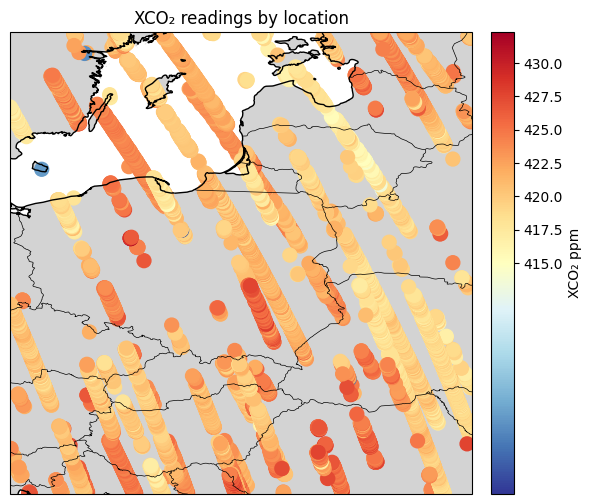

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

baseline = 415
min = merged['xco2'].min() if merged['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([
    merged['lon'].min(), merged['lon'].max(),
    merged['lat'].min(), merged['lat'].max()
], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(
    merged['lon'], 
    merged['lat'], 
    c=merged['xco2'], 
    s=100,
    cmap='RdYlBu_r', 
    norm=norm,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, label='XCO₂ ppm')

plt.title('XCO₂ readings by location')

plt.show()

In [46]:
from scipy.spatial import cKDTree

def idw_interpolate(lon, lat, values, lon_grid, lat_grid, k=8, power=2):
    pts = np.column_stack((lon, lat))
    grid_pts = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    tree = cKDTree(pts)
    dist, idx = tree.query(grid_pts, k=k, n_jobs=-1)           # (Ngrid, k)
    # if k==1 shapes differ; ensure arrays
    dist = np.maximum(dist, 1e-12)
    weights = 1.0 / (dist**power)
    z = np.sum(weights * values[idx], axis=1) / np.sum(weights, axis=1)
    return z.reshape(lon_grid.shape)

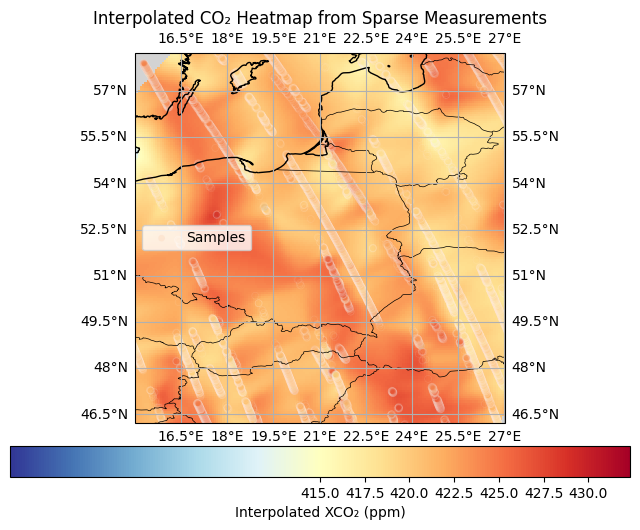

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
baseline = 415
min = merged['xco2'].min() if merged['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)
points = np.column_stack((merged['lon'], merged['lat']))
values = merged['xco2']

lon_grid = np.linspace(merged['lon'].min(), merged['lon'].max(), 200)
lat_grid = np.linspace(merged['lat'].min(), merged['lat'].max(), 200)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

grid_xco2 = griddata(points, values, (lon_mesh, lat_mesh), method='linear')
grid_xco2 = gaussian_filter(grid_xco2, sigma=2)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_extent([
    merged['lon'].min() + 1,
    merged['lon'].max() - 1,
    merged['lat'].min() + 1,
    merged['lat'].max() - 1
])
ax.gridlines(draw_labels=True)

img = ax.pcolormesh(
    lon_mesh, lat_mesh, grid_xco2,
    cmap='RdYlBu_r', shading='auto', norm=norm
)
plt.colorbar(img, label='Interpolated XCO₂ (ppm)', orientation='horizontal', pad=0.05)

ax.scatter(merged['lon'], merged['lat'], c=merged['xco2'], cmap='RdYlBu_r', s=25, label='Samples', norm=norm, edgecolors='white', alpha=0.1, linewidth=.5)
plt.legend()
plt.title('Interpolated CO₂ Heatmap from Sparse Measurements')
plt.show()

In [62]:
top_clean_spots = merged.sort_values('xco2', inplace=False, ascending=True)
top_clean_spots = top_clean_spots[top_clean_spots['xco2'] < 417]
top_clean_spots

,sounding_id,xco2,time,lat,lon,cluster
21361,2.024101e+15,412.793396,2024-10-14 11:39:17.895009280,46.49,20.45,74
9529,2.024060e+15,413.031799,2024-06-01 11:35:08.255003392,53.22,19.21,92
2095,2.024032e+15,413.157379,2024-03-15 11:22:00.416025856,48.72,24.29,88
16983,2.024082e+15,413.426331,2024-08-20 11:36:36.642011392,58.58,16.27,105
20710,2.024092e+15,413.537750,2024-09-19 11:48:32.227991040,55.07,14.97,146
...,...,...,...,...,...,...
17814,2.024090e+15,416.996399,2024-09-04 10:53:51.642003200,56.53,23.89,240
20572,2.024092e+15,416.997559,2024-09-19 11:48:03.614990336,53.37,15.83,18
17385,2.024083e+15,416.998596,2024-08-25 11:52:20.281994496,48.56,16.56,30
16135,2.024082e+15,416.999054,2024-08-15 11:15:46.614995456,50.94,24.87,73


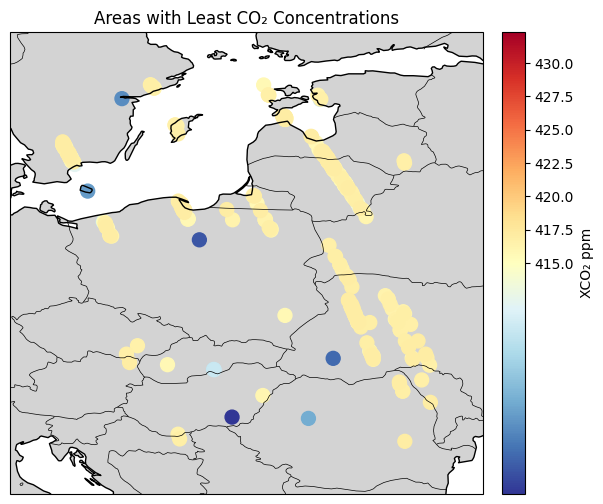

In [63]:
baseline = 415
min = top_clean_spots['xco2'].min() if top_clean_spots['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([
    top_clean_spots['lon'].min() - 2, top_clean_spots['lon'].max() + 2,
    top_clean_spots['lat'].min() - 2, top_clean_spots['lat'].max() + 2
], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(
    top_clean_spots['lon'], 
    top_clean_spots['lat'], 
    c=top_clean_spots['xco2'], 
    s=100,
    cmap='RdYlBu_r', 
    norm=norm,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, label='XCO₂ ppm')

plt.title('Areas with Least CO₂ Concentrations')

plt.show()

In [56]:
top_polluted_spots = merged.sort_values('xco2', inplace=False, ascending=False)
top_polluted_spots = top_polluted_spots[top_polluted_spots['xco2'] > 426]
top_polluted_spots

,sounding_id,xco2,time,lat,lon,cluster
22683,2.025010e+15,432.323364,2025-01-02 11:41:38.615026432,52.97,17.66,121
22684,2.025010e+15,431.773895,2025-01-02 11:41:38.642022912,52.97,17.67,121
22682,2.025010e+15,429.612518,2025-01-02 11:41:38.587989760,52.98,17.65,121
22365,2.024123e+15,429.047546,2024-12-28 11:21:22.255017728,46.19,25.08,154
3071,2.024032e+15,428.941864,2024-03-22 11:27:30.975005440,47.18,23.38,156
...,...,...,...,...,...,...
22296,2.024120e+15,426.013336,2024-12-03 11:29:18.588020480,51.29,21.35,97
2960,2.024032e+15,426.012451,2024-03-22 11:27:07.416010240,45.74,23.94,84
22235,2.024120e+15,426.010437,2024-12-03 11:29:09.642021888,50.75,21.61,130
22332,2.024120e+15,426.003326,2024-12-03 11:29:20.615005952,51.40,21.31,97


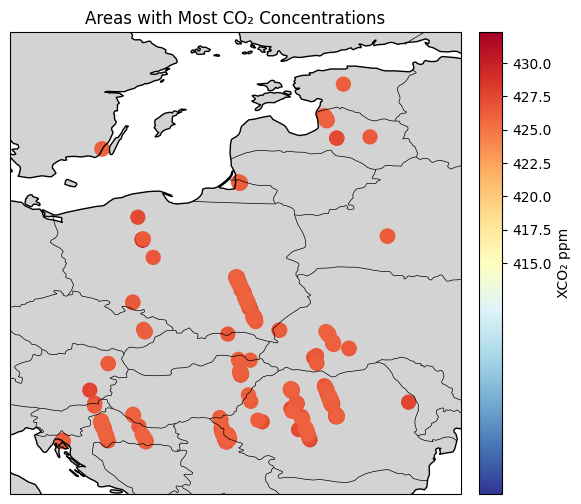

In [57]:
baseline = 415
min = top_polluted_spots['xco2'].min() if top_polluted_spots['xco2'].min() < baseline else baseline - 1
norm = mcolors.TwoSlopeNorm(
    vmin=min, 
    vcenter=baseline, 
    vmax=merged['xco2'].max()
)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([
    top_polluted_spots['lon'].min() - 2, top_polluted_spots['lon'].max() + 2,
    top_polluted_spots['lat'].min() - 2, top_polluted_spots['lat'].max() + 2
], crs=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(
    top_polluted_spots['lon'], 
    top_polluted_spots['lat'], 
    c=top_polluted_spots['xco2'], 
    s=100,
    cmap='RdYlBu_r', 
    norm=norm,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, label='XCO₂ ppm')

plt.title('Areas with Most CO₂ Concentrations')

plt.show()